Hello everyone,

In this module, it is required to implement the feature extractor for Arabic Font Identification System.

At first, what are the main steps that we should go through in this module?


# TODOs:

1. Understand the problem
2. ..
3. Testing

# 1. Understand the problem

Calligraphers use some specific features, The main aim of this step is to transform these features into values that can be fed to a machine so it can decide on the style of a given text image. It should be mentioned that a feature might specify one or more styles. Features designated for each style or set of styles might be used in a sequential manner (sequential
decision) or parallel manner.



- Input: --
- Output: --

In [23]:
##################################################### imports #####################################################
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from scipy import ndimage
from skimage.feature import local_binary_pattern


# 2. Text thickness (Tth)
Stroke thickness plays an important role in defining the style. Some styles use a flat pen, whereas some others use a pointed one. In some styles, calligraphers alter the thickness while writing (via pushing down the pen or the opposite), whereas in others, the thickness is always preserved. Modeling such a feature in form of a descriptor will help the machine to understand more specificities of each style. Text thickness (Tth) descriptor codifies the appearance frequency of different line thicknesses in a text image. To extract this descriptor, we employ both the skeleton and edge image, and thickness is determined by the distance between skeleton and edges.

In [24]:
def Tth(skeleton_img, edge_img, bins=5):
    """Gets normalized histogram of text thickness 

    Args:
        skeleton_img: the image extracted skeleton
        edge_img: the image extracted edges
        
    Returns:
        hist : 1d array contains the normalized histogram values
        bin_edges : 1d array contains the bin edges values
    """

    skeleton = skeleton_img.copy()
    edge = edge_img.copy()

    # convert img to uint8 with 255:white 0:black

    if skeleton.max() == 1:
        skeleton = skeleton * 255
        skeleton = skeleton.astype(np.uint8)

    if edge.max() == 1:
        edge = edge * 255
        edge = edge.astype(np.uint8)

    # flipping edge => black text on white background
    edge = 255 - edge

    distance = cv2.distanceTransform(edge+skeleton, distanceType=cv2.DIST_L2, maskSize=5)
    # keeping only skeleton distances
    distance[skeleton==0] = 0
    
    h, h_bins = np.histogram(distance, range=(1, distance.max()), density=False, bins=bins)

    # normalizing the histogram
    h_sum = h.sum()
    if h_sum > 1:
        h = h/h_sum

    return h

# 3. Special Diacritics (SDs)
Thuluth and Mohakik have a similar writing style that is decorated with diacritics having special shapes, as shown in Figure 9:
<img src="sds.png" alt="Figure 9" width="100"/>
An SDs descriptor will be used to inspect the existence of such diacritics in a given text image. To this end, HuMoments is calculated for the contours of the two diacritics in Figure 9.
Thereafter,  a score is calculated for a test image by calculating the distance between the two pre-calculated HuMoments and the test image diacritics contours HuMoments.


In [25]:

def precalculate_hu(path="sds.png", save=False, save_filename="sds_hue_moments"):
    """Utility function used by SDs to calculate hu moments for each contour, from one image contains diactritics
        
    Args:
        path: the path for the diactritics image
        save: if true, it will store the calculated values in sds_hue_moments
        save_filename: the filename in case of save=true, (default = sds_hue_moments)
    Returns:
        hu_moments: the calculated hu moments
    """

    # importing binarize from preprocessing module
    import sys
    sys.path.insert(1, "./../preprocessing/")
    from preprocessing import binarize

    sds_img = binarize(cv2.imread(path, 0))
    
    contours, _ = cv2.findContours(image=sds_img.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    hu_moments = []
    for contour in contours:
        moments = cv2.moments(contour)
        hu = cv2.HuMoments(moments)
        hu = np.array(hu).flatten()
        hu_moments.append(hu)

    hu_moments = np.array(hu_moments)
    
    if save:
        np.save(save_filename, hu_moments)

    return hu_moments

In [26]:
def SDs(img, recalculate=False, hu_file="sds_hue_moments.npy", path="sds.png"):
    """Gets an input image of the diacritics image and return a score determines how those diacritics are similar to mohakek and thuluth
        
    Args:
        diacritics_image: A binary image containing only diacritics (white text on black bg)
        recalculate: recalculate precalculate humoments values (default = False)
        path: path of image to recalculate humoments from (default = "sds.png")
        hu_file: file to read precalculated hu_moments from it or write to it in case of recalculate = True (default = "sds_hue_moments.npy")

    Returns:
        score: determine how those diacritics are similar to mohakek and thuluth (more similar => larger score)
    """
    
    # sd1 = np.array([2.40895486e-01, 4.84043539e-03, 1.38924440e-03, 3.48145819e-04, -6.47404757e-08, 6.90885170e-06, -2.33304273e-07])
    # sd2 = np.array([3.54057491e-01, 3.05011527e-03, 3.44288395e-02, 7.77674538e-04, 3.14350358e-06, 4.13909592e-05, -2.51216325e-06])


    if recalculate:
        sd = precalculate_hu(path, True, hu_file)
    else:
        sd = np.load(hu_file)

    contours, _ = cv2.findContours(image=img.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    hu_moments1 = []
    hu_moments2 = []
    
    for contour in contours:
        moments = cv2.moments(contour)
        hu = cv2.HuMoments(moments)
        hu = np.array(hu).flatten()
        d1 = np.linalg.norm(sd[0] - hu)
        d2 = np.linalg.norm(sd[1] - hu)
        hu_moments1.append(d1)
        hu_moments2.append(d2)
        # hu_moments.append(hu)

    # moments = cv2.moments(np.array(hu_moments))
    # hu = cv2.HuMoments(moments)

    # return hu.flatten()
    min_hu_moments = np.minimum(hu_moments1, hu_moments2)

    if len(min_hu_moments) > 0:
        max_hu = 1/min_hu_moments.sum()
    else:
        max_hu = 0

    return [max_hu]

In [27]:
def Diacritics(d_img):
    """Gets an input image of the diacritics image and return a score determines how those diacritics are similar to mohakek and thuluth
        
    Args:
        diacritics_image: A binary image containing only diacritics (white text on black bg)
        recalculate: recalculate precalculate humoments values (default = False)
        path: path of image to recalculate humoments from (default = "sds.png")
        hu_file: file to read precalculated hu_moments from it or write to it in case of recalculate = True (default = "sds_hue_moments.npy")

    Returns:
        score: determine how those diacritics are similar to mohakek and thuluth (more similar => larger score)
    """
    
    # contours_d, _ = cv2.findContours(image=d_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    # contours_t, _ = cv2.findContours(image=t_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    # areas = []
    # for contour in contours:
    #     area = cv2.contourArea(contour)
    #     areas.append(area)

    # area_ratio = sum(areas)/(d_img.shape[0]*d_img.shape[1]) 
    # return [d_img.sum()/img.sum()]    
    # return cv2.matchShapes(d_img, im, cv2.CONTOURS_MATCH_I1, 0)
    return cv2.HuMoments(cv2.moments(d_img)).flatten()

# 4. Words Orientation (WOr)
One of the salient features of the Diwani style is the words written in a slanted format. WOr descriptor mainly specifies how, on average, words in text are oriented. the orientation of each word contour (without diacritics) is calculated and then a mean oriatation is calculated weighted by the area of each word contour.
WOr algorithm was used to distinguish Diwani from other styles. Diwani style yieldan orientation average of about 45 degrees compared to 0 degrees by other styles.


In [28]:
def WOr(img, debug=False):
    """Gets an input image of the text without diacritics and return the mean orientation of words
        
    Args:
        text_only_image: A binary image containing only text wihtout diacritics (white text on black bg)
        debug: if true, show the bounding box of words (default False)
    Returns:
        orientation_mean: the weighted mean of words orientation
    """

    contours, _ = cv2.findContours(image=img.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    orientations = []
    areas = []
    img = img.copy()
    if debug:
        rgb_img = cv2.cvtColor(img*255, cv2.COLOR_GRAY2RGB)

    # [vx,vy,x,y] = cv2.fitLine(contours[-1], cv2.DIST_L2,0,0.01,0.01)
    # return vx,vy,x,y
    # print(len(contours))
    for contour in contours:

        rows,cols = img.shape[:2]
        [vx,vy,x,y] = cv2.fitLine(contour, cv2.DIST_L2,0,0.01,0.01)
        # lefty = int((-x*vy/vx) + y)
        # righty = int(((cols-x)*vy/vx)+y)
        # cv2.line(img,(cols-1,righty),(0,lefty),(255,255,255),2)
        angle = np.rad2deg(np.arctan2(vy[0], vx[0]))
        area = cv2.contourArea(contour)

        orientations.append(angle)
        areas.append(area)
        continue
        rect = cv2.minAreaRect(contour)
        p, dimensions, orientation = rect
        # orientations.append(np.abs(orientation) % 60)
        orientations.append(np.abs(orientation))
        x,y,w,h = cv2.boundingRect(contour)
        # areas.append(h*w)
        areas.append(dimensions[0]*dimensions[1])
        # areas.append(w*h)
        # areas.append(w)
        
        if debug:
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(rgb_img,[box],0,(255,255,255),1)
    

    # # if debug:
    # plt.imshow(img, cmap="gray")
    # return 0

    # sum_areas = np.sum(areas)
    # if sum_areas > 0:
    #     # weighted_mean = np.dot(areas, orientations) / sum_areas
    #     weighted_mean = orientations[np.argmax(areas)]
    # else:
    #     weighted_mean = 0


    m = 3
    n = len(areas)
    if len(areas) > m:
        n = m

    w = []

    if len(orientations) > 0:
        w.append(np.var(orientations))
        w.append(np.mean(orientations))
        # w.append(orientations[np.argmax(areas)])
    else:
        w.append(0)
        w.append(0)
        # w.append(0)

    max_n = np.argpartition(areas, -n)[-n:]
    for i in range(len(max_n)-1,-1,-1):
        w.append(orientations[i])

    for i in range(m-n):
        w.append(0)

    # return [weighted_mean]
    return w
    


In [29]:
def HVSL(edge_image):
    """(Horizontal & Vertical Straight Lines Descriptor)
    Gets the edge image as input and returns a vector of length 2 containing the features:
        a- The appearance frequency of vertical and horizontal lines.
        b- The ratio between the number of the pixels that constitute the texts' edges and the V/H lines' pixels.

    Params:
        edge_image: An image containing only the edges.
        
    Returns:
        HVSL_features: a vector containing the two features mentioned above 
    """

    # A constant defining the minimum percentage of the row/column that a line should have
    # The number of consecutive pixels divided by the total height/width should be at least this ratio to be considered a line
    MINIMUM_VLINE_LENGTH_PERCENTAGE = 0.02
    MINIMUM_HLINE_LENGTH_PERCENTAGE = 0.015

    height, width = edge_image.shape
    vertical_horizontal_lines_freq = 0
    
    vertical_size = max(int(MINIMUM_VLINE_LENGTH_PERCENTAGE * height), 1)
    horizontal_size = max(int(MINIMUM_HLINE_LENGTH_PERCENTAGE * width), 1)
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
    mask1 = cv2.morphologyEx(edge_image, cv2.MORPH_OPEN, horizontalStructure)
    mask2 = cv2.morphologyEx(edge_image, cv2.MORPH_OPEN, verticalStructure)
    
    contours_h, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_v, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes_h = [cv2.boundingRect(contour) for contour in contours_h]
    bounding_boxes_v = [cv2.boundingRect(contour) for contour in contours_v]
    vertical_lines = [bounding_box[3] for bounding_box in bounding_boxes_v]
    horizontal_lines = [bounding_box[2] for bounding_box in bounding_boxes_h]

    vertical_horizontal_lines_pixels = sum(vertical_lines) + sum(horizontal_lines)
    vertical_horizontal_lines_freq = len(vertical_lines) + len(horizontal_lines)

    edge_pixels = edge_image.sum()

    lines_edges_ratio = vertical_horizontal_lines_pixels / edge_pixels

    HVSL_features = [vertical_horizontal_lines_freq, lines_edges_ratio]

    return HVSL_features



In [30]:
def LVL(skeleton_image):
    """(Long Vertical Lines Descriptor)
    Gets the skeleton image as input and returns a vector of length 5 containing the features:
        a- The text height from the bottom to top.
        b- The number of detected vertical lines.
        c- The length of the highest detected vertical line.
        d- The ratio between the text height and the highest vertical line.
        e- The variance among the vertical lines.

    Params:
        skeleton_image: An image with the skeletonized version of the original input image.
        
    Returns:
        LVL_features: a vector containing the five features mentioned above 
    """
    # TODO Crop the input image to remove the spaces between the text and the border

    # A constant defining the minimum percentage of the column that a line should have
    # The number of consecutive pixels divided by the total height should be at least this ratio to be considered a line
    MINIMUM_VLINE_LENGTH_PERCENTAGE = 0.03

    vertical_lines_freq = 0
    height, width = skeleton_image.shape
    vertical_lines = []
    vertical_size = max(int(MINIMUM_VLINE_LENGTH_PERCENTAGE * height), 1)
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))

    mask2 = cv2.morphologyEx(skeleton_image, cv2.MORPH_OPEN, verticalStructure)
    
    contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    vertical_lines = [bounding_box[3] for bounding_box in bounding_boxes]
    vertical_lines_freq = len(bounding_boxes)

    if vertical_lines_freq < 1:
        highest_vertical_line_length = 0
        vertical_lines_variance = 0
    else:
        highest_vertical_line_length = max(vertical_lines)
        vertical_lines_variance = np.var(vertical_lines)

    text_height = height
    if text_height < 1:
        highest_vertical_line_to_text_height_ratio = 0
    else:   
        highest_vertical_line_to_text_height_ratio = highest_vertical_line_length / text_height
    

    LVL = [text_height, vertical_lines_freq, highest_vertical_line_length, highest_vertical_line_to_text_height_ratio, vertical_lines_variance]
    
    return LVL



In [31]:
def ToE_ToS(image, bins=9):
    """(Text orientation from Edges / Text orientation from Skeleton Descriptor)
    Finds the orientation of edges / skeleton image by applying a sobel filter to capture the intensities of edges 
        and the orientation of these edges 

    Params:
        image: An image with the skeletonized / edge version of the original input image.
        
    Returns:
        ToE/ToS: a vector containing the intensities and orientations of the pixels
    """
    
    Kx = np.array([[-2, 0, 2], 
                   [-1, 0, 1], 
                   [-2, 0, 2]], np.float32)

    Ky = np.array([[2, 1, 2], 
                   [0, 0, 0], 
                   [-2, -1, -2]], np.float32)
    
    Ix = ndimage.filters.convolve(image, Kx)
    Iy = ndimage.filters.convolve(image, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max()
    # G = G[G != 0]
    theta = np.arctan2(Iy, Ix)
    # theta = theta[theta != 0]

    Gs, _ = np.histogram(G, bins=bins)
    # Gs = np.append(Gs, np.var(G))
    thetas, _ = np.histogram(theta, bins=bins)
    # thetas = np.append(thetas, np.var(theta))
    G_sum = Gs.sum()
    if G_sum > 1:
        Gs = Gs / G_sum 
    T_sum = thetas.sum()
    if T_sum > 1:
        thetas = thetas / T_sum

    return np.append(Gs, thetas)

In [32]:
# # importing io module
# import sys
# sys.path.insert(1, "./../io_utils/")
# sys.path.insert(1, "./../preprocessing/")
# from io_utils import read_data, read_classes
# from preprocessing import *
# # reading data and class names
# classes_names = read_classes('../ACdata_base/names.txt')
# dataset_images, dataset_labels = read_data('../ACdata_base/')


In [33]:
def HPP(image, bins=10):
    """(Horizontal Profile Projection)
    Finds the projection of the horizontal lines in an image and allocate them to specific bins based on their positions

    Params:
        image: A binary image
        
    Returns:
        h: a vector containing the number of pixels in each bin 
    """
    white_pixels_in_row = image.sum(axis=1)

    h, h_bins = np.histogram(white_pixels_in_row, range=(1, white_pixels_in_row.max()), density=False, bins=bins)

    # normalizing the histogram
    h_sum = h.sum()
    if h_sum > 1:
        h = h/h_sum

    return h

In [ ]:
def LBP(image):

    lbp = local_binary_pattern(image, 6, 1.5, method='nri_uniform').flatten()

    h, _ = np.histogram(lbp, bins=100)

    # normalizing the histogram
    h_sum = h.sum()
    if h_sum > 1:
        h = h/h_sum
    
    return h

# 3. Testing

In [40]:
def testing():
    # import randrange
    from random import randrange
    # importing io module
    import sys
    sys.path.insert(1, "./../io_utils/")
    from io_utils import read_data, read_classes

    # importing preprocessing module
    sys.path.insert(1, "./../preprocessing/")
    from preprocessing import binarize, extract_edges, extract_skeleton, separate_diacritics_and_text, crop

    # reading data and class names
    classes_names = read_classes('../ACdata_base/names.txt')
    dataset_images, dataset_labels = read_data('../ACdata_base/')
    
    assert len(dataset_images) == len(dataset_labels)

    # get the range of each class in the dataset
    ranges = [0]
    tmp = dataset_labels[0]
    for idx, num in enumerate(dataset_labels):
        if num != tmp:
            tmp = num
            ranges.append(idx)
    ranges.append(len(dataset_labels))

    # test_image = cv2.imread("../ACdata_base/7/1124.jpg",0)
    # diacritics_image, text_image = separate_diacritics_and_text(test_image)
    # wor = WOr(text_image, True)
    # print(wor)

    # Choosing a random example from each class and apply the preprocessing Functions on it
    for i, class_name in enumerate(classes_names):
        # break
        index = randrange(ranges[i], ranges[i+1])
        test_image = dataset_images[index]
        binary_image = binarize(test_image)
        cropped_image = crop(binary_image)
        skeleton_image = extract_skeleton(binary_image).astype(np.uint8)
        edge_image = extract_edges(binary_image)
        diacritics_image, text_image = separate_diacritics_and_text(binary_image)

        assert len(np.unique(np.asarray(binary_image))) == 2

        tth = Tth(skeleton_image, edge_image)
        # sds = SDs(diacritics_image)[0]
        # d_1, d_2 = Diacritics(diacritics_image, text_image)
        # d = Diacritics(diacritics_image, cropped_image)
        wor = WOr(text_image)[0]
        hpp = HPP(cropped_image)
        lvl = LVL(skeleton_image) #list of 5
        hvsl = HVSL(edge_image) #list of 2
        toe = ToE_ToS(edge_image,10) #list of 2
        tos = ToE_ToS(skeleton_image,10) #list of 2

        f, axarr = plt.subplots(1,1, figsize=(10, 7))

        suptitle = "Tth: " + np.array2string(tth)
        # suptitle += "\nSDs: " + str(sds)
        # suptitle += "\nSDs: " + str(d_1) + " " + str(d_2) + " " + str(d_1/d_2)
        # suptitle += "\nSDs: " + str(d)
        suptitle += "\nWOr: " + str(wor)
        suptitle += "\nToE: " + np.array2string(toe)
        suptitle += "\nToS: " + np.array2string(tos)
        suptitle += "\nHPP: " + str(hpp)
        suptitle += "\nHVSL: " + str(hvsl)
        suptitle += "\nLVL: " + str(lvl)
        f.suptitle(suptitle)

        axarr.imshow(cropped_image, cmap='gray')
        axarr.set_title(class_name)


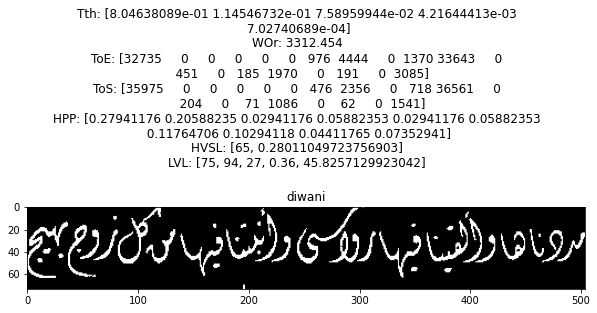

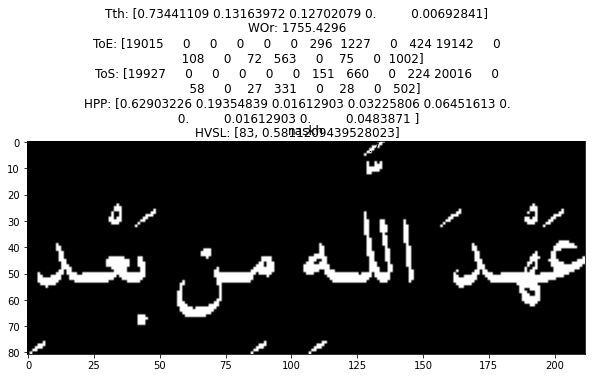

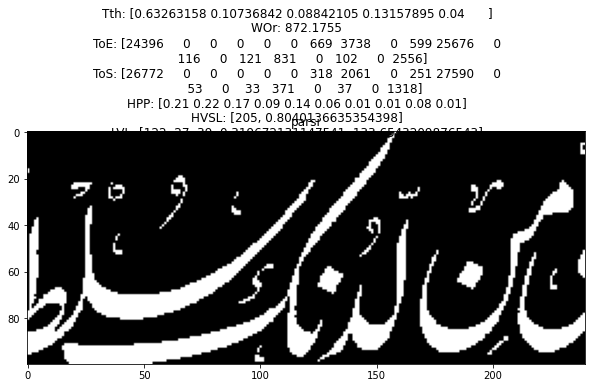

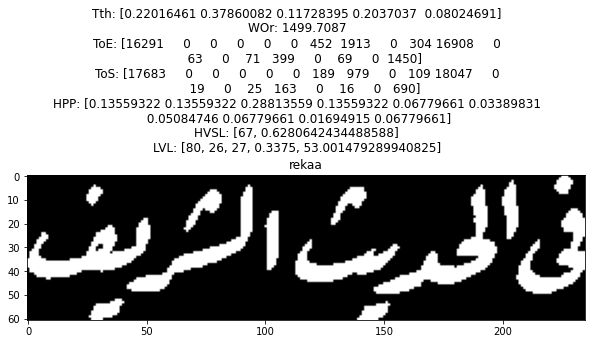

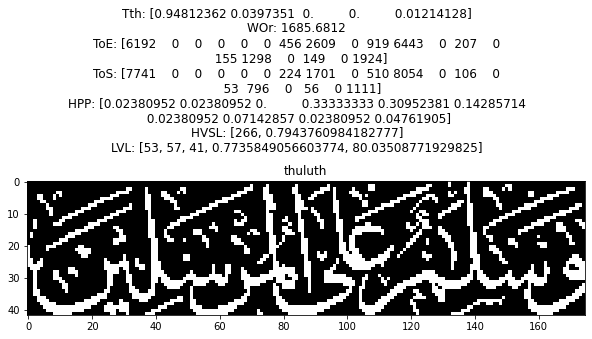

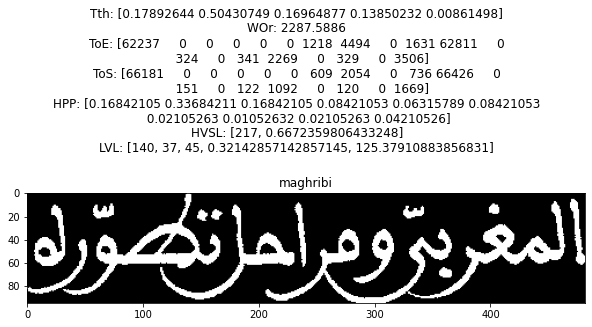

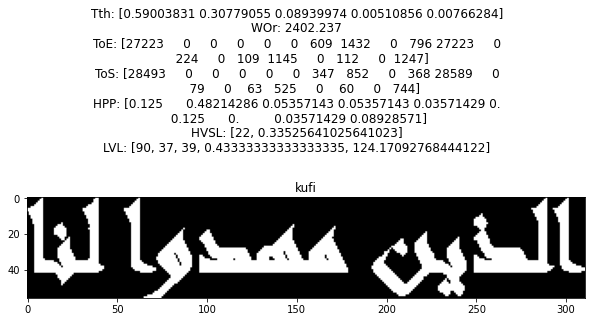

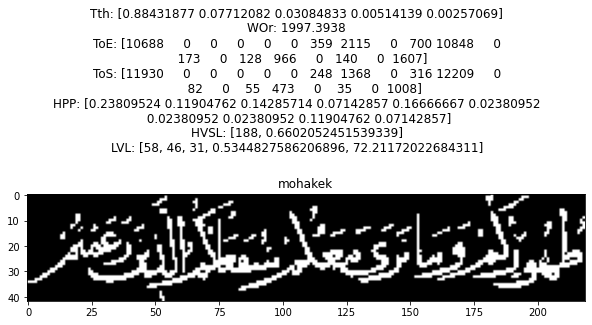

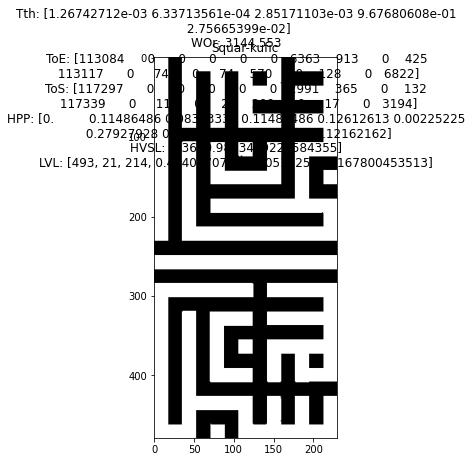

In [41]:
# if __name__ == '__main__':
#     testing()

In [36]:
def create_py():
    !jupyter nbconvert --to script feature_extraction.ipynb

In [37]:
if __name__ == '__main__':
    create_py()

'jupyter' is not recognized as an internal or external command,
operable program or batch file.
